# Inspecting DeepConsensus examples and running model

## Imports



Run these in order. These libraries are finicky about which order they're installed and loaded in.

In [ ]:
! pip install --upgrade pip setuptools wheel
! pip install deepconsensus[cpu]==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.org/simple
  Using cached https://test-files.pythonhosted.org/packages/6e/01/790fbf619116eac308509c1c029bf303ff6684afea77742b43dd150da6ec/deepconsensus-1.1.0-py3-none-any.whl (157 kB)
  Using cached tf_models_official-2.9.2-py2.py3-none-any.whl (2.1 MB)
  Using cached ml_collections-0.1.1-py3-none-any.whl
  Using cached pandas-1.5.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached intel_tensorflow-2.9.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (232.6 MB)
  Using cached sacrebleu-2.3.1-py3-none-any.whl (118 kB)
  Using cached tensorflow_addons-0.19.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached tensorflow_text-2.9.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
  Using 

In [ ]:
import tensorflow as tf
import colorama
import numpy as np
import random
import PIL
from IPython.display import display
from deepconsensus.models import model_configs
from deepconsensus.models import model_utils
from deepconsensus.models import data_providers
from deepconsensus.utils import dc_constants

## Define some useful visualization utilities

In [ ]:
def plot_array(arr, scale = 5):
  """Transforms array for plotting."""
  arr = np.copy(arr).astype('float64')
  arr = np.where(arr > 1.0e-10, arr, -10.0)
  arr = np.log(arr, where=arr > 0.0, out=arr) * 100.0
  arr = np.where(arr > 0, arr + 25.0, 0)
  arr = arr.astype('uint8')
  im = PIL.Image.fromarray(arr, 'P')
  im = im.resize((im.size[0] * scale, im.size[1] * scale))
  display(im)

def show_rows_for_one_example(rows, max_passes=20):
  """Break out the black/white matrix into subreads, ccs, PW, IP, etc.

  For each of `max_subreads`, we have four pieces of information: bases, PW, IP,
  and strand. We also have one row for CCS, and four rows for SN (in that
  order).
  The information is structured as follows:
  Bases: rows 0 to  (params.max_passes - 1)
  PW: rows (params.max_passes) to (params.max_passes * 2 - 1)
  IP: rows (params.max_passes * 2) to (params.max_passes * 3 - 1)
  Strand: rows (params.max_passes * 3) to (params.max_passes * 4 - 1)
  CCS+SN: rows (params.max_passes * 4) to (params.max_passes * 4 + 5)
  """
  print('bases:')
  plot_array(rows[0:max_passes])
  print('PW: pulse-width')
  pw = rows[max_passes:max_passes*2]
  plot_array(pw)
  print('IP: inter-pulse duration')
  ip = rows[max_passes*2:max_passes*3]
  plot_array(ip)

  print('Strand:')
  plot_array(rows[max_passes*3:-5])

  print('CCS:')
  ccs = rows[-5:-4]
  plot_array(ccs)
  print('SN:')
  sn = rows[-4:]
  plot_array(sn)

In [ ]:
def encoded_sequence_to_string(encoded_sequence):
  """Convert an encoded sequence (a series of integers) to a DNA string."""
  return ''.join([dc_constants.SEQ_VOCAB[int(base)] for base in encoded_sequence])


def get_ccs_matrix(rows_for_one_example):
  """Slice the encoded CCS out of the 2d rows matrix of one example."""
  return rows_for_one_example[-5, :]


def get_ccs_seq(rows_for_one_example):
  """Get CCS string out of the 2d rows matrix of one example."""
  return encoded_sequence_to_string(get_ccs_matrix(rows_for_one_example))


def colorful(seq):
  """Add colors to a sequence of DNA."""
  fore = colorama.Fore
  background = colorama.Back
  colors = {
      'A': fore.GREEN,
      'C': fore.BLUE,
      'G': fore.YELLOW,
      'T': fore.RED,
      dc_constants.GAP: background.WHITE
  }
  reset = fore.BLACK + background.RESET
  colored_seq = [f'{colors.get(base, reset)}{base}{reset}' for base in seq]
  return ''.join(colored_seq)


def show_example(batch, example_i, ypreds=None, max_passes=20):
  """Show an example with subreads, ccs, predictions, and labels."""
  batch_size = batch['rows'].shape[0]
  rows = batch['rows'][example_i, :, :, 0]
  ccs_i = get_ccs_seq(rows)
  print(f'Example: {example_i} of {batch_size} (batch)')
  print('How the sequences are represented for the model:')
  subreads = rows[0:max_passes, :]
  for subread_i in range(len(subreads)):
    print(f'Subread {subread_i + 1}\t',
          colorful(encoded_sequence_to_string(subreads[subread_i, :])))
  print('ccs:\t\t', colorful(ccs_i))
  if ypreds is not None:
    predicted_sequence = encoded_sequence_to_string(ypreds[example_i])
    print('prediction:\t', colorful(predicted_sequence))
  if 'label' in batch:
    label = encoded_sequence_to_string(batch['label'][example_i])
    print('label:\t\t', colorful(label))
  print('\n')


## Load the model

In [ ]:
# Download Model
! mkdir -p deepconsensus_model
! gsutil cp -r gs://brain-genomics-public/research/deepconsensus/models/v1.1/model_checkpoint/* deepconsensus_model/
# Download test data
! gsutil cp gs://brain-genomics-public/research/deepconsensus/training-tutorial/v1.1/test/tf-test-00000-of-00500.tfrecord.gz ./tf-test.tfrecord.gz

Copying gs://brain-genomics-public/research/deepconsensus/models/v1.1/model_checkpoint/checkpoint.data-00000-of-00001...
Copying gs://brain-genomics-public/research/deepconsensus/models/v1.1/model_checkpoint/checkpoint.index...
Copying gs://brain-genomics-public/research/deepconsensus/models/v1.1/model_checkpoint/params.json...
- [3 files][ 85.7 MiB/ 85.7 MiB]                                                
Operation completed over 3 objects/85.7 MiB.                                     
Copying gs://brain-genomics-public/research/deepconsensus/training-tutorial/v1.1/test/tf-test-00000-of-00500.tfrecord.gz...
/ [1 files][  6.9 MiB/  6.9 MiB]                                                
Operation completed over 1 objects/6.9 MiB.                                      


In [ ]:
checkpoint_path = 'deepconsensus_model/checkpoint'
params = model_utils.read_params_from_json(checkpoint_path=checkpoint_path)

model = model_utils.get_model(params)
checkpoint = tf.train.Checkpoint(model=model)

row_size = data_providers.get_total_rows(params.max_passes)
input_shape = (1, row_size, params.max_length, params.num_channels)
model_utils.print_model_summary(model, input_shape)
checkpoint.restore(
    checkpoint_path).expect_partial().assert_existing_objects_matched()

model_utils.modify_params(
  params=params,
  speedy=True,
  max_length=100,
  is_training=False)

Model: "encoder_only_learned_values_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 relative_position_embedding  multiple                 0         
  (RelativePositionEmbedding                                     
 )                                                               
                                                                 
 encoder_stack (EncoderStack  multiple                 7320200   
 )                                                               
                                                                 
 dense (Dense)               multiple                  1405      
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
 bases_embedding (ModifiedOn  multiple                 40        
 DeviceEmbedding)          

# Load examples from tfrecords

In [ ]:
tfrecord_path = 'tf-test.tfrecord.gz'

# Number of examples:
batch_size = 20  #@param

ds = data_providers.get_dataset(tfrecord_path,
                                num_epochs=None,
                                batch_size=batch_size,
                                params=params,
                                inference=False)

# Just get one batch to inspect:
for batch in ds.take(1):
  break

keys = ['name', 'label', 'rows', 'num_passes', 'window_pos']
for key in keys:
  print(f'{key}.shape: {batch[key].shape}')

name.shape: (20, 1)
label.shape: (20, 100)
rows.shape: (20, 85, 100, 1)
num_passes.shape: (20, 1)
window_pos.shape: (20, 1)


## Visualize the rows of one example. This is what the model sees.

Rows is of shape `[batch_size, input_size, length, 1]`.

So when we take `rows[example_i,:,:,0]`, that is one example in the batch, and we get a 2D matrix (getting rid of the last dimension that was only a placeholder for model code).

Example: 13 of 20 (batch)
ZMW: b'm64014_200920_132517/50332363/ccs'
window_pos: 21345 bp (where example starts within the CCS read)
num_passes: 5 subreads
What the model sees:


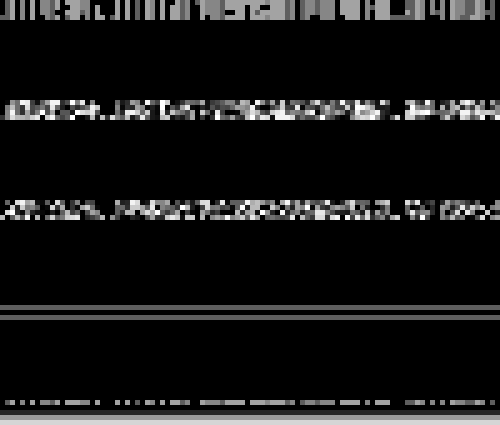

In [ ]:
example_i = int(random.random() * batch_size)

print(f'Example: {example_i} of {batch_size} (batch)')
print('ZMW:', batch['name'][example_i].numpy()[0])
print('window_pos:', int(batch['window_pos'][example_i].numpy()), 'bp (where example starts within the CCS read)')
print('num_passes:', int(batch['num_passes'][example_i]), 'subreads')
print('What the model sees:')

plot_array(batch['rows'][example_i,:,:,0].numpy())


### Let's break that down

Each matrix is composed of multiple data types layered in rows. The bases, pulse-width, inter-pulse duration, and strand are per-subread, up to the max number of subreads (this is in params.max_passes, which as of DeepConsensus v1.1 is 20). The input also contains a draft circular consensus sequence (CCS) from PacBio and the signal-to-noise ratio (SN).

Example: 13 of 20 (batch)
bases:


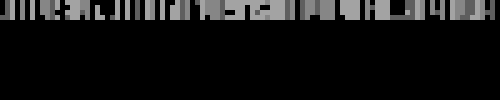

PW: pulse-width


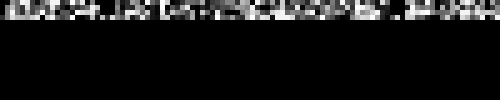

IP: inter-pulse duration


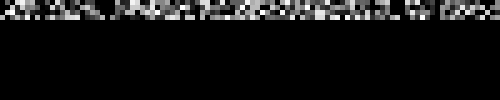

Strand:


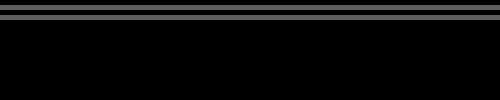

CCS:


SN:


In [ ]:
print(f'Example: {example_i} of {batch_size} (batch)')
show_rows_for_one_example(rows=batch['rows'][example_i,:,:,0].numpy())

# Run the model

Run the model on `rows`, which is the input data for the model that we visualized above.

In [ ]:
softmax_output = model.predict(batch['rows'])
print(softmax_output.shape)

(20, 100, 5)


In [ ]:
y_preds = np.argmax(softmax_output, -1)
print(y_preds.shape)

(20, 100)


### Interpreting y_preds output

In [ ]:
prediction = y_preds[example_i]
print(f'Prediction for example {example_i}:')
print(prediction)
print('Which translates to:')
print(encoded_sequence_to_string(prediction))

Prediction for example 13:
[0 2 4 1 3 1 4 1 3 3 2 4 1 0 4 4 0 3 1 4 0 0 0 4 1 4 1 2 1 4 3 1 4 1 4 4 2
 3 1 0 4 3 3 3 2 4 4 4 4 1 4 4 4 3 4 4 4 2 3 1 2 3 3 2 3 3 3 1 4 4 4 4 1 3
 1 4 4 4 0 0 0 2 2 4 3 1 3 0 3 1 4 3 3 2 2 4 3 0 2 1]
Which translates to:
 TGACAGACCTGA GG CAG   GAGATAGCAGAGGTCA GCCCTGGGGAGGGCGGGTCATCCTCCCAGGGGACAGGG   TTGCAC CAGCCTTGC TA


In [ ]:
print('For reference, the alphabet is:')
print('\n'.join([f'{i} -> "{s}"' for i,s in enumerate(dc_constants.SEQ_VOCAB)]))

For reference, the alphabet is:
0 -> " "
1 -> "A"
2 -> "T"
3 -> "C"
4 -> "G"


# Visualize example sequences alongside prediction and label

In [ ]:
show_example(batch, example_i, ypreds=y_preds)

Example: 13 of 20 (batch)
How the sequences are represented for the model:
Subread 1	  TGACAGACCTGAGGGCCA    GAGATAGCAGA GTCATGCCCTGGGGGGGGCGGGTCATCCTCCCAGGGGACAGGG   TTGCAC CAGCCTTGC TA
Subread 2	  TGACAGACCTGA GGCCAG   GAGATAGCAGAGGTCA GCCCTGGGGAGG  GGGTCATCCTCCCAGGGGACTGGG   TTGCAC CAGCCTTGC TA
Subread 3	  TGACAGACCT AGGGTCAG   GAGATAGCAGAGGTCA GCCCT  GGAGTGGGGGTCATCCTCCCAGGGGACAGGG   GTGCACTCAGCCTTGCTTA
Subread 4	 TTGACAGA CTGATGG CAGGATGAGATAGCAGAGGTCA G CCTGGGGAGGGCGGGTCATCAACCCA GGGACAGGGTTTTTGCA  CAGCTTGGC TA
Subread 5	                                                                                                     
Subread 6	                                                                                                     
Subread 7	                                                                                                     
Subread 8	                                                                                                     
Subread 9	                   